## ROMY Array - Map

### Importing

In [1]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees

from andbro__querrySeismoData import __querrySeismoData



In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [30]:
from functions.read_DEM import __read_DEM
from functions.array_latlon_to_xyz import __array_latlon_to_xyz

### Setting Variables

In [25]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2024-03-13 12:00")
config['tend'] = obspy.UTCDateTime("2024-03-13 18:00")


config['seeds'] = [
                   'BW.GELB..HH*',
                   'BW.GRMB..HH*',
                   'BW.ALFT..HH*',
                   'BW.BIB..HH*',
                   'BW.TON..HH*',
                   'BW.FFB1..HH*',
                   'BW.FFB2..HH*',
                   'BW.FFB3..HH*',
                   'BW.DROMY..HH*',
                   'GR.FUR..HH*',
]

config['fmin'] = 0.001
config['fmax'] = 0.2


config['ref_station'] = 'BW.DROMY..HH*'

config['client'] = RoutingClient("eida-routing")

### Defining Methods

In [26]:
def __get_array_stations(seeds, tbeg, tend):

    route =  RoutingClient("eida-routing")

    for _i, seed in enumerate(seeds):

        net, sta, loc, cha = seed.split(".")


        inv =route.get_stations(
                                network=net,
                                station=sta,
                                channel=cha,
                                starttime=tbeg,
                                endtime=tend,
                                # latitude=ref_coords[0],
                                # longitude=ref_coords[1],
                                # minradius=0,
                                # maxradius=max_radius,
                            )
        if _i == 0:
            invs = inv
        else:
            invs += inv

    # inv_check.plot(projection="local");

    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(invs):
        for i, station in enumerate(network):

            codes.append(f'{invs[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)

    # create dataframe
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev': elev})

    # sort the dataframe
    frame.sort_values(by="codes", inplace=True)

    return frame

In [27]:
array_stations = __get_array_stations(config['seeds'], config['tbeg'], config['tend'])

In [28]:
array_stations

,codes,lon,lat,elev
2,BW.ALFT,11.279500,48.142334,0.593
3,BW.BIB,11.247300,48.152200,0.599
8,BW.DROMY,11.275476,48.162941,0.571
5,BW.FFB1,11.275065,48.162904,0.572
6,BW.FFB2,11.273684,48.164357,0.577
7,BW.FFB3,11.276289,48.164883,0.562
0,BW.GELB,11.251400,48.162900,0.628
1,BW.GRMB,11.263500,48.140600,0.656
4,BW.TON,11.288809,48.173897,0.564
9,GR.FUR,11.276800,48.163900,0.565


### Add xyz and UTM

In [8]:
array_stations = __array_latlon_to_xyz(array_stations, ref_station=config['ref_station'])

In [9]:
array_stations

,codes,lon,lat,elev,x_m,y_m,z_m,utm_n,utm_e,utm_zone,utm_letter
3,BW.ALFT,11.279500,48.142334,0.593,367.11,-2281.38,22.0,5.334633e+06,669567.346291,32.0,U
10,BW.BIB,11.247300,48.152200,0.599,-2060.10,-1255.39,28.0,5.335659e+06,667140.137071,32.0,U
7,BW.DRMY1,11.275473,48.162877,0.571,-0.01,-7.12,0.0,5.336907e+06,669200.222527,32.0,U
11,BW.DRMY2,11.275394,48.162975,0.571,-6.21,3.60,0.0,5.336918e+06,669194.026128,32.0,U
2,BW.DRMY3,11.275561,48.162972,0.571,6.22,3.63,0.0,5.336918e+06,669206.453092,32.0,U
5,BW.DRMY4,11.275332,48.162769,0.571,-10.14,-19.43,0.0,5.336895e+06,669190.093938,32.0,U
6,BW.DRMY5,11.275020,48.162958,0.572,-33.96,0.89,1.0,5.336915e+06,669166.273712,32.0,U
13,BW.DRMY6,11.275565,48.163080,0.573,6.16,15.64,2.0,5.336930e+06,669206.395145,32.0,U
14,BW.DRMY7,11.276804,48.165591,0.571,90.02,297.44,0.0,5.337212e+06,669290.252532,32.0,U
15,BW.DROMY,11.275476,48.162941,0.571,0.00,0.00,0.0,5.336915e+06,669200.235012,32.0,U


## Compute station distance

In [32]:
from functions.calculate_distance_of_stations import __calculate_distance_of_stations

In [11]:
distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=config['ref_station'])
distances

{'BW.ALFT': 2.31,
 'BW.BIB': 2.4,
 'BW.DRMY1': 0.01,
 'BW.DRMY2': 0.01,
 'BW.DRMY3': 0.01,
 'BW.DRMY4': 0.02,
 'BW.DRMY5': 0.03,
 'BW.DRMY6': 0.02,
 'BW.DRMY7': 0.31,
 'BW.DROMY': 0.0,
 'BW.FFB1': 0.03,
 'BW.FFB2': 0.21,
 'BW.FFB3': 0.22,
 'BW.GELB': 1.78,
 'BW.GRMB': 2.63,
 'BW.ROMY': 0.0,
 'BW.TON': 1.57}

In [12]:
cross_distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=None)
cross_distances

array([[0.  , 1.54, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.56, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 3.57, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 3.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.59, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.59, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.57, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 4.14, 0.  , 0.  , 0.  , 0.  , 0.  

### Calulcate Distances, Plot Array Geometry and Response

In [13]:
def __plot_array_geometry_and_response(array, transff, klim, kstep, names=None, unit=None):

    import numpy as np

    # calulcate geometrical center of array
    array_center = [np.median(array[:, 0]), np.median(array[:, 1])]

    # find geometrical limits of array
    lon_min, lon_max = np.min(array[:, 0]), np.max(array[:, 0])
    lat_min, lat_max = np.min(array[:, 1]), np.max(array[:, 1])

    # define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim


    # _________________________________________________________
    #
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12

    if unit == "km":
        xdata = (array[:, 0]-array_center[0])*111.
        ydata = (array[:, 1]-array_center[1])*111. * np.cos(array[:,1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)

    elif unit == "deg":
        xdata = array[:, 0]
        ydata = array[:, 1]
        x0, y0 = array_center[0], array_center[1]

    # ________________________________________________
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata))*0.99, max(abs(ydata))*1.01])
        axes[0].set_xlim([-max(abs(xdata))*0.99, max(abs(xdata))*1.01])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

        axes[0].set_ylim([min(abs(ydata))*0.9999, max(abs(ydata))*1.0001])
        axes[0].set_xlim([min(abs(xdata))*0.999, max(abs(xdata))*1.001])

    axes[0].set_title('Array Stations', fontsize=fs+2)

    for x, y, s in zip(xdata, ydata, list(names)):
        axes[0].text(x, y, s, ha="right", va="top")

    # ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
                         np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
                         transff.T, cmap=obspy_sequential,
                        )

    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('Array Response Function', fontsize=fs+2)

    plt.show();

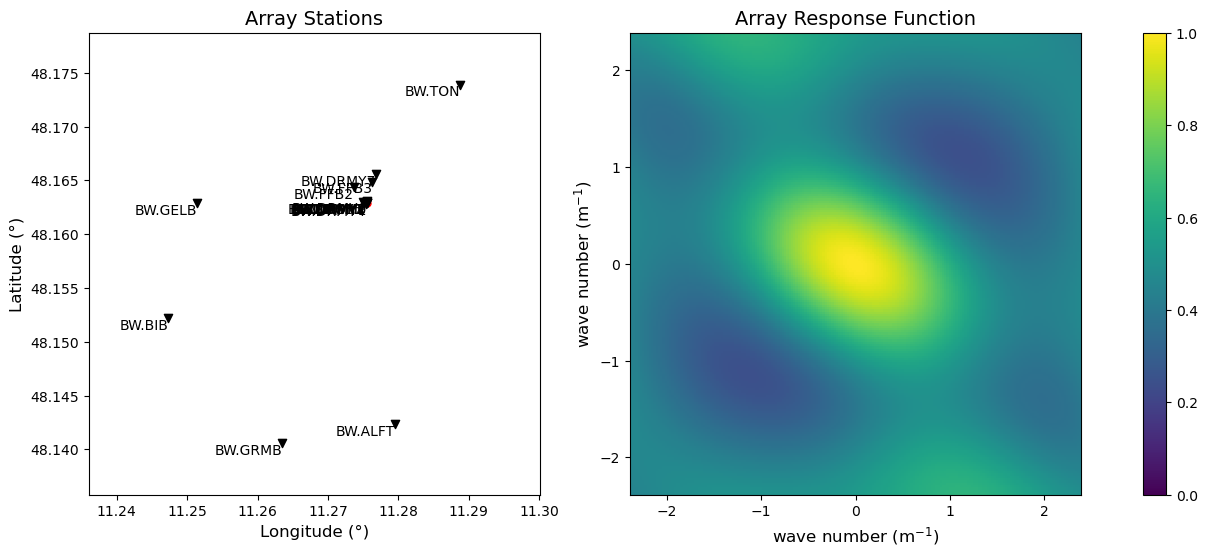

In [14]:
# get maximal distance
dist_max = max(distances.values())

lambda_min = 1*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )


__plot_array_geometry_and_response(coordinates,
                                   transff,
                                   config['k_max'],
                                   config['k_step'],
                                   array_stations.codes,
                                   unit="deg",
                                  )
